In [1]:
# %load genetic_algorithm_conversion_facebook.py
#!/usr/bin/env python

# In[4]:

import math
import numpy as np
# from GAIndividual import GAIndividual
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import index_collector_conversion_facebook
sizepop, vardim, MAXGEN, params = 500, 8, 15, [0.9, 0.1, 0.5]
DATABASE = "dev_facebook_test"
DATE = datetime.datetime.today().date() -datetime.timedelta(1)
OBJECTIVE_LIST = [ 'CONVERSIONS', 'ADD_TO_CART', ]
COST_PER_ACTION = {
    'CONVERSIONS':'cost_per_purchase',
    'ADD_TO_CART':'cost_per_add_to_cart',
    'LANDING_PAGE_VIEW':'cost_per_landing_page_view',
}

class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
#         self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#         self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        self.trace[self.t, 0] = self.best.fitness
        self.trace[self.t, 1] = self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print("Optimal solution is:")
        print("m1--m2--m3--m4--m5--m6--mspend--mbid")
        print(self.best.chrom)
        self.printResult()
        return self.best.chrom
    
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] +                         (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()


class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] +                 (self.bound[1, i] - self.bound[0, i]) * rnd[i]
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = ObjectiveFunc().fitness_function( self.chrom, df )

class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''
    def __init__(self, campaign_id=None):
        self.mydb = index_collector_conversion_facebook.connectDB( DATABASE )
        self.charge_type = 'CONVERSIONS'
    def fitness_function(self, optimal_weight, df):
        df = df.fillna(0)

        m1 = (df['purchase'] / df['add_to_cart']).iloc[0]
        m2 = 0
        m3 = (df['add_to_cart'] / df['view_content']).iloc[0]
        m4 = (df['view_content'] / df['landing_page_view']).iloc[0]
        m5 = (df['landing_page_view'] / df['link_click']).iloc[0]
        m6 = (df['link_click'] / df['impressions']).iloc[0]
        m_spend = -(( df['daily_budget'] - df['spend'] ) / df['daily_budget']).iloc[0]
        m_bid   = (( df['campaign_bid'] - df[ COST_PER_ACTION[self.charge_type] ] ) / df['campaign_bid']).iloc[0]
        status  = np.array( [m1, m2, m3, m4, m5, m6, m_spend, m_bid] )
        status = np.nan_to_num(status)
        r = np.dot( optimal_weight, status )
        return r

    def adset_fitness(optimal_weight, df, charge_type):
        df = df.fillna(0)

        m1 = (df['purchase'] / df['add_to_cart']).iloc[0]
        m2 = 0
        m3 = (df['add_to_cart'] / df['view_content']).iloc[0]
        m4 = (df['view_content'] / df['landing_page_view']).iloc[0]
        m5 = (df['landing_page_view'] / df['link_click']).iloc[0]
        m6 = (df['link_click'] / df['impressions']).iloc[0]
        m_spend = -(( df['daily_budget'] - df['spend'] ) / df['daily_budget']).iloc[0]
        m_bid   = (( df['bid_amount'] - df[ COST_PER_ACTION[charge_type] ] ) / df['bid_amount']).iloc[0]
        
        status  = np.array( [m1, m2, m3, m4, m5, m6, m_spend, m_bid] )
#         for idx, j in enumerate(status[:,0]):
#             if np.isinf(j) or np.isneginf(j):
#                 status[idx,0] = -100
        status = np.nan_to_num(status)
        r = np.dot( optimal_weight, status )
        r = np.nan_to_num(r)
#         if math.isinf(r[0,0]):
#             r[0,0] = -10
        return r
    
    def campaign_status( self, campaign_id ):
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        df_metrics = pd.read_sql("SELECT * FROM campaign_conversion_metrics WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        df_camp['campaign_bid'] = df_camp['ai_spend_cap']/df_camp['destination']
        self.charge_type = df_camp['charge_type'].iloc[0]

        spend = df_camp['spend'].iloc[0]
        campaign_cost_per_target = df_camp['cost_per_target'].iloc[0]
        campaign_target = df_camp['target'].iloc[0]
        impressions = df_camp['impressions'].iloc[0]
        df=pd.DataFrame(
            {
                'campaign_id':[ campaign_id ],
                'campaign_cost_per_target':[ campaign_cost_per_target ],
                'campaign_target':[ campaign_target ],
                'campaign_bid':[ df_camp['campaign_bid'].iloc[0] ],
                'daily_budget':[ df_camp['daily_budget'].iloc[0] ],
                'charge_type':[ df_camp['charge_type'].iloc[0] ]
            }
        )
        df = pd.merge( df, df_metrics, on=['campaign_id'] )
        df.fillna(value=0, inplace=True)
        df = df.convert_objects(convert_numeric=True)
        return df
    
    def adset_status( self, adset_id ):
        df=pd.DataFrame({'adset_id':[],'target':[], 'impressions':[], 'bid_amount':[]})

        df_adset = pd.read_sql("SELECT * FROM adset_conversion_metrics WHERE adset_id={} and DATE(request_time) = '{}' ORDER BY request_time DESC LIMIT 1".format(adset_id, DATE), con=self.mydb)
        df_adset.fillna(value=0, inplace=True)
        return df_adset

def ga_optimal_weight(campaign_id, df_weight):
    request_time = datetime.datetime.now().date()
    mydb = index_collector_conversion_facebook.connectDB( DATABASE )
#     df_weight = pd.read_sql("SELECT * FROM conversion_optimal_weight WHERE campaign_id={}".format(campaign_id), con=mydb)
    df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id={}".format(campaign_id), con=mydb)
    charge_type = df_camp['charge_type'].iloc[0]
    adset_list = index_collector_conversion_facebook.Campaigns(campaign_id, charge_type).get_adsets_active()
    for adset_id in adset_list:
        df = ObjectiveFunc().adset_status( adset_id )
        df['daily_budget'] = df_camp['daily_budget']
        df['add_to_cart'].iloc[0] = df['purchase'].iloc[0] if df['add_to_cart'].iloc[0] < df['purchase'].iloc[0] else df['add_to_cart'].iloc[0]
        df['view_content'].iloc[0] = df['add_to_cart'].iloc[0] if df['view_content'].iloc[0] < df['add_to_cart'].iloc[0] else df['view_content'].iloc[0]
        df['landing_page_view'].iloc[0] = df['view_content'].iloc[0] if df['landing_page_view'].iloc[0] < df['view_content'].iloc[0] else df['landing_page_view'].iloc[0]
        r = ObjectiveFunc.adset_fitness( df_weight, df, charge_type )
        print(adset_id, r)
        df_final = pd.DataFrame({'campaign_id':campaign_id, 'adset_id':adset_id, 'score':r[0], 'request_time':request_time}, index=[0])

        index_collector_conversion_facebook.insertion("adset_score", df_final)

In [2]:
def main(campaign_id=None):
    starttime = datetime.datetime.now()
    global df
    if not campaign_id:
        campaign_list = index_collector_conversion_facebook.get_running_conversion_campaign()['campaign_id'].unique()
        print('[on-going cnvrsn campaign_list]: ', campaign_list)
        for campaign_id in campaign_list:
            df = ObjectiveFunc().campaign_status(campaign_id)
            df = df.fillna(0)
            df['add_to_cart'].iloc[0] = df['purchase'].iloc[0] if df['add_to_cart'].iloc[0] < df['purchase'].iloc[0] else df['add_to_cart'].iloc[0]
            df['view_content'].iloc[0] = df['add_to_cart'].iloc[0] if df['view_content'].iloc[0] < df['add_to_cart'].iloc[0] else df['view_content'].iloc[0]
            df['landing_page_view'].iloc[0] = df['view_content'].iloc[0] if df['landing_page_view'].iloc[0] < df['view_content'].iloc[0] else df['landing_page_view'].iloc[0]
            print('campaign_id:', campaign_id )
            print('current time: ', starttime )
            bound = np.tile([[0], [10]], vardim)
            ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
            optimal = ga.solve()
            score = ObjectiveFunc().fitness_function(optimal, df)
            score = np.nan_to_num(score)
            if math.isinf(score):
                print('[main] score is inf, stop assessment')
                return
            weight_columns=['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w_spend', 'w_bid']
            df_weight = pd.DataFrame(data=[optimal], columns=weight_columns, index=[0])

            df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
            df_final = pd.concat( [df_weight, df_final], axis=1, sort=True, ignore_index=False)
            try:
                index_collector_conversion_facebook.check_optimal_weight(campaign_id, df_final)
                ga_optimal_weight(campaign_id, df_weight)
            except:
                pass
            print('optimal_weight:', optimal)
            print(datetime.datetime.now()-starttime)
        print(datetime.datetime.now()-starttime)
    else:
        print('campaign_id:', campaign_id )
        print('current time: ', starttime )
        df = ObjectiveFunc().campaign_status(campaign_id)
        df['add_to_cart'].iloc[0] = df['purchase'].iloc[0] if df['add_to_cart'].iloc[0] < df['purchase'].iloc[0] else df['add_to_cart'].iloc[0]
        df['view_content'].iloc[0] = df['add_to_cart'].iloc[0] if df['view_content'].iloc[0] < df['add_to_cart'].iloc[0] else df['view_content'].iloc[0]
        df['landing_page_view'].iloc[0] = df['view_content'].iloc[0] if df['landing_page_view'].iloc[0] < df['view_content'].iloc[0] else df['landing_page_view'].iloc[0]
        bound = np.tile([[0], [10]], vardim)
        ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
        optimal = ga.solve()
        score = ObjectiveFunc().fitness_function(optimal, df)
        if math.isinf(score):
            print('[main] score is inf, stop assessment')
            return
        weight_columns=['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w_spend', 'w_bid']
        df_weight = pd.DataFrame(data=[optimal], columns=weight_columns, index=[0])

        df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
        df_final = pd.concat( [df_weight, df_final], axis=1, sort=True, ignore_index=False)
        index_collector_conversion_facebook.check_optimal_weight(campaign_id, df_final)
        ga_optimal_weight(campaign_id, df_weight)
        print('optimal_weight:', optimal)
        print('[time taken]: ', datetime.datetime.now()-starttime)    
    print(datetime.datetime.now()-starttime)
    return

[on-going cnvrsn campaign_list]:  [23843467729120098 23843318864630344 23843346060540647 23843412097900531
 23843484377040702 23844119639930337 23843347342450014 23843463181270680
 23843429637800443]
campaign_id: 23843467729120098


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:284: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/home/tim_su/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Generation 0: optimal function value is: 61.511823; average function value is 33.850665
Generation 1: optimal function value is: 61.511823; average function value is 38.607163
Generation 2: optimal function value is: 61.511823; average function value is 41.891638
Generation 3: optimal function value is: 61.511823; average function value is 42.494015
Generation 4: optimal function value is: 61.511823; average function value is 43.616846
Generation 5: optimal function value is: 61.511823; average function value is 44.591661
Generation 6: optimal function value is: 61.511823; average function value is 45.103724
Generation 7: optimal function value is: 61.511823; average function value is 45.310785
Generation 8: optimal function value is: 61.511823; average function value is 45.583779
Generation 9: optimal function value is: 61.511823; average function value is 45.795344
Generation 10: optimal function value is: 61.511823; average function value is 45.605966
Generation 11: optimal function

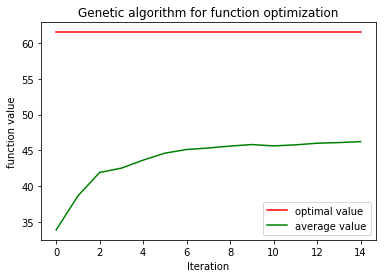

[get_adsets_active] adset_active_list: ['23843467729820098', '23843514167650098', '23843524438380098', '23843525092430098', '23843530601710098', '23843530797790098']
23843467729820098 [13.34523142]
23843514167650098 [16.26619649]
23843524438380098 [18.82672841]
23843525092430098 [19.20443113]
23843530601710098 [13.94911147]
23843530797790098 [19.52935027]
optimal_weight: [6.48285958 3.64465425 3.08412252 9.45154052 9.97446018 9.0083095
 9.287392   9.10819854]
0:00:38.143410
campaign_id: 23843318864630344
Generation 0: optimal function value is: 134.375743; average function value is 36.963995
Generation 1: optimal function value is: 134.375743; average function value is 78.285818
Generation 2: optimal function value is: 134.378112; average function value is 88.136722
Generation 3: optimal function value is: 134.378112; average function value is 91.224445
Generation 4: optimal function value is: 134.378112; average function value is 93.419666
Generation 5: optimal function value is: 134.

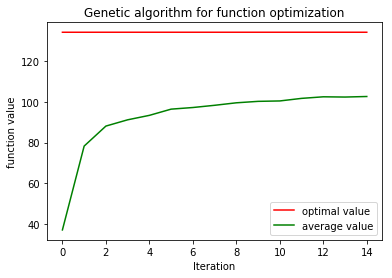

[get_adsets_active] adset_active_list: ['23843345016640344', '23843349026350344', '23843349045180344']
23843345016640344 [-8.21505665]
23843349026350344 [-8.20584573]
23843349045180344 [-8.10238559]
optimal_weight: [5.08965722 3.49210567 8.43069877 7.98197122 9.73070572 3.19666036
 9.21092426 0.99586761]
0:01:12.281469
campaign_id: 23843346060540647
Generation 0: optimal function value is: 148.737606; average function value is 68.410893
Generation 1: optimal function value is: 148.737606; average function value is 89.957334
Generation 2: optimal function value is: 148.737606; average function value is 96.552188
Generation 3: optimal function value is: 148.737606; average function value is 100.083445
Generation 4: optimal function value is: 148.737606; average function value is 102.085833
Generation 5: optimal function value is: 148.737606; average function value is 103.220671
Generation 6: optimal function value is: 148.737606; average function value is 105.129068
Generation 7: optimal

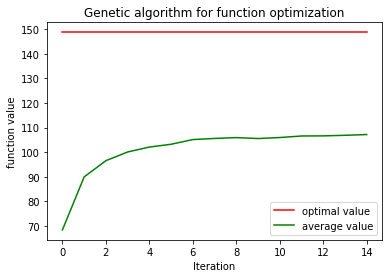

[get_adsets_active] adset_active_list: ['23843346099470647', '23843346104340647', '23843364647520647']
23843346099470647 [6.15165463]
23843346104340647 [14.66561451]
23843364647520647 [4.34517494]
optimal_weight: [8.83720179 0.95893685 2.02412105 1.76002871 7.89468023 5.83411612
 9.87544899 0.70607998]
0:01:46.170365
campaign_id: 23843412097900531
Generation 0: optimal function value is: 31.175218; average function value is 14.758000
Generation 1: optimal function value is: 31.175218; average function value is 16.943042
Generation 2: optimal function value is: 31.175218; average function value is 18.485403
Generation 3: optimal function value is: 31.175218; average function value is 19.551763
Generation 4: optimal function value is: 31.175218; average function value is 20.540972
Generation 5: optimal function value is: 31.175218; average function value is 21.089074
Generation 6: optimal function value is: 31.175218; average function value is 21.814824
Generation 7: optimal function val

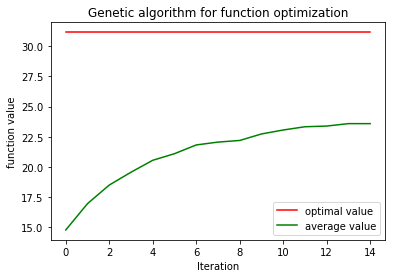

[get_adsets_active] adset_active_list: ['23843412097910531', '23843412097990531', '23843440715690531', '23843443382310531', '23843444264380531']
23843412097910531 [19.80953692]
23843412097990531 [-2.64977547]
23843440715690531 [16.61795331]
23843443382310531 [-2.66534172]
23843444264380531 [-6.2264977]
optimal_weight: [9.99278319 6.26051362 2.80510996 9.93782314 9.63266563 6.12641051
 6.2264977  3.56115598]
0:02:21.574906
campaign_id: 23843484377040702
Generation 0: optimal function value is: 63.070784; average function value is 33.955422
Generation 1: optimal function value is: 63.070784; average function value is 37.972290
Generation 2: optimal function value is: 63.070784; average function value is 40.566801
Generation 3: optimal function value is: 63.070784; average function value is 41.118523
Generation 4: optimal function value is: 63.070784; average function value is 42.347047
Generation 5: optimal function value is: 63.070784; average function value is 42.524079
Generation 6: o

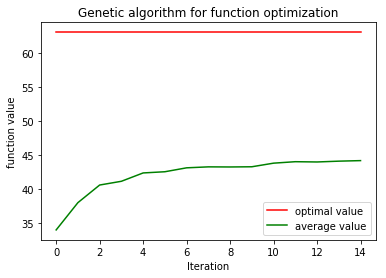

[get_adsets_active] adset_active_list: ['23843484398710702', '23843484398730702', '23843484398840702', '23843509167940702']
23843484398710702 [-5.62778185]
23843484398730702 [-5.62778185]
23843484398840702 [-5.61785101]
23843509167940702 [7.64661122]
optimal_weight: [4.29007868 4.66027886 3.83780638 9.33468311 8.19200766 7.13872153
 9.9308407  4.30305885]
0:02:55.971797
campaign_id: 23844119639930337
Generation 0: optimal function value is: 25.333866; average function value is 13.666212
Generation 1: optimal function value is: 25.333866; average function value is 15.815669
Generation 2: optimal function value is: 25.333866; average function value is 16.584491
Generation 3: optimal function value is: 25.333866; average function value is 16.868507
Generation 4: optimal function value is: 25.333866; average function value is 17.176315
Generation 5: optimal function value is: 25.333866; average function value is 17.448308
Generation 6: optimal function value is: 25.333866; average function

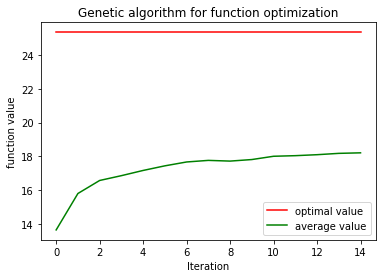

[get_adsets_active] adset_active_list: ['23844119644430337', '23844119644610337', '23844119644620337', '23844119755470337', '23844148431910337', '23844155264710337']
23844119644430337 [9.31135662]
23844119644610337 [10.33769829]
23844119644620337 [9.22405042]
23844119755470337 [-0.59151934]
23844148431910337 [10.06816688]
23844155264710337 [10.91351427]
optimal_weight: [0.32833408 0.83334793 6.95368558 9.19167911 9.44840841 4.52250805
 9.40382999 8.7652915 ]
0:03:32.519825
campaign_id: 23843347342450014
Generation 0: optimal function value is: 37.544143; average function value is 14.577220
Generation 1: optimal function value is: 37.544143; average function value is 18.529220
Generation 2: optimal function value is: 37.544143; average function value is 20.853544
Generation 3: optimal function value is: 37.544143; average function value is 22.186067
Generation 4: optimal function value is: 37.544143; average function value is 23.435140
Generation 5: optimal function value is: 37.544143;

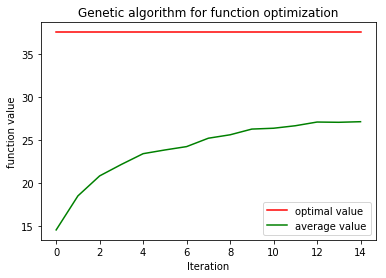

[get_adsets_active] adset_active_list: ['23843347343720014', '23843347343730014', '23843347343750014', '23843347343760014']
23843347343720014 [-3.80399473]
23843347343730014 [22.78012991]
23843347343750014 [5.63118267]
23843347343760014 [-2.96472932]
optimal_weight: [9.79672527 8.32867947 0.29131054 8.60590525 9.37059001 0.97177593
 4.23159029 0.42759556]
0:04:06.884034
campaign_id: 23843463181270680
Generation 0: optimal function value is: 95.266417; average function value is 52.784156
Generation 1: optimal function value is: 95.266417; average function value is 59.638943
Generation 2: optimal function value is: 95.266417; average function value is 63.682615
Generation 3: optimal function value is: 95.266417; average function value is 66.038778
Generation 4: optimal function value is: 95.266417; average function value is 67.075567
Generation 5: optimal function value is: 95.266417; average function value is 68.027940
Generation 6: optimal function value is: 95.266417; average function

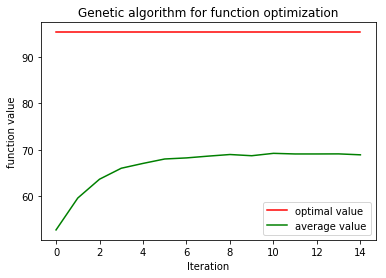

[get_adsets_active] adset_active_list: ['23843463181250680', '23843463181310680', '23843463181320680', '23843472966790680']
23843463181250680 [0.47760713]
23843463181310680 [17.70321869]
23843463181320680 [22.08533675]
23843472966790680 [-0.05733934]
optimal_weight: [1.51804356 8.82222208 6.8682069  6.37290497 8.53295309 7.90105333
 9.90641616 9.84907682]
0:04:41.293013
campaign_id: 23843429637800443
Generation 0: optimal function value is: 33.061174; average function value is 18.105522
Generation 1: optimal function value is: 33.061174; average function value is 20.404324
Generation 2: optimal function value is: 33.061174; average function value is 21.857979
Generation 3: optimal function value is: 33.061174; average function value is 22.084580
Generation 4: optimal function value is: 33.061174; average function value is 22.184173
Generation 5: optimal function value is: 33.061174; average function value is 22.827369
Generation 6: optimal function value is: 33.061174; average function

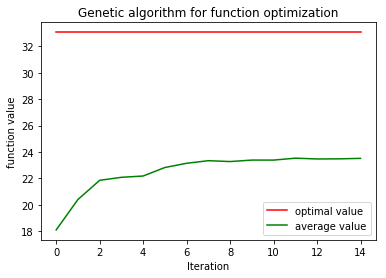

[get_adsets_active] adset_active_list: ['23843429637840443', '23843442486080443']
23843429637840443 [14.00230624]
23843442486080443 [0.41873838]
optimal_weight: [7.61774632 3.53188655 9.21121033 4.9085998  8.8246721  2.67020339
 9.36605185 9.78479023]
0:05:14.305741
0:05:14.305783
0:05:14.305804


In [3]:
if __name__ == "__main__":
    main()
    import gc
    gc.collect()
#     main(23843318864630344)